# Lecture 2B - Single-Atom-Lasing

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
# setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from qutip import (Options, about, basis, destroy, expect, mesolve, ptrace,
                   qeye, sigmax, steadystate, tensor, wigner)

%matplotlib inline

# Introduction and model

Consider a single atom coupled to a single cavity mode, as illustrated in the figure below. If there atom excitation rate $\Gamma$ exceeds the relaxation rate, a population inversion can occur in the atom, and if coupled to the cavity the atom can then act as a photon pump on the cavity.

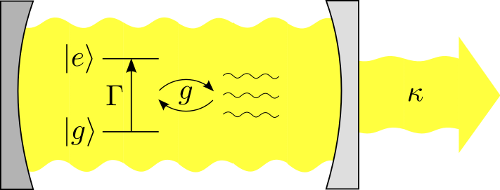

In [2]:
Image(filename="images/schematic-lasing-model.png")

The coherent dynamics in this model is described by the Hamiltonian

$H = \hbar \omega_0 a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g\sigma_x(a^\dagger + a)$

where $\omega_0$ is the cavity energy splitting, $\omega_a$ is the atom energy splitting and $g$ is the atom-cavity interaction strength.

In addition to the coherent dynamics the following incoherent processes are also present: 

1. $\kappa$ relaxation and thermal excitations of the cavity, 
2. $\Gamma$ atomic excitation rate (pumping process).

The Lindblad master equation for the model is:

$$\frac{d}{dt}\rho = -i[H, \rho] + \Gamma\left(\sigma_+\rho\sigma_- - \frac{1}{2}\sigma_-\sigma_+\rho - \frac{1}{2}\rho\sigma_-\sigma_+\right)
+ \kappa (1 + n_{\rm th}) \left(a\rho a^\dagger - \frac{1}{2}a^\dagger a\rho - \frac{1}{2}\rho a^\dagger a\right)
+ \kappa n_{\rm th} \left(a^\dagger\rho a - \frac{1}{2}a a^\dagger \rho - \frac{1}{2}\rho a a^\dagger\right)$$

in units where $\hbar = 1$.

References:

 * [Yi Mu, C.M. Savage, Phys. Rev. A 46, 5944 (1992)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.46.5944)

 * [D.A. Rodrigues, J. Imbers, A.D. Armour, Phys. Rev. Lett. 98, 067204 (2007)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.067204)

 * [S. Ashhab, J.R. Johansson, A.M. Zagoskin, F. Nori, New J. Phys. 11, 023030 (2009)](http://dx.doi.org/10.1088/1367-2630/11/2/023030)

### Problem parameters

In [3]:
w0 = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength

kappa = 0.04  # cavity dissipation rate
gamma = 0.00  # atom dissipation rate
Gamma = 0.35  # atom pump rate

N = 50  # number of cavity fock states
n_th_a = 0.0  # avg number of thermal bath excitation

tlist = np.linspace(0, 150, 101)

### Setup the operators, the Hamiltonian and initial state

In [4]:
# initial state
psi0 = tensor(basis(N, 0), basis(2, 0))  # start without excitations

# operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())

# Hamiltonian
H = w0 * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * sx

### Create a list of collapse operators that describe the dissipation

In [5]:
# collapse operators
c_ops = []

rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

rate = Gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm.dag())

### Evolve the system

Here we evolve the system with the Lindblad master equation solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_+\sigma_-$ are returned by the solver by passing the list `[a.dag()*a, sm.dag()*sm]` as the fifth argument to the solver.

In [6]:
opt = Options(nsteps=2000)  # allow extra time-steps
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm],
                 options=opt)

## Visualize the results

Here we plot the excitation probabilities of the cavity and the atom (these expectation values were calculated by the `mesolve` above).

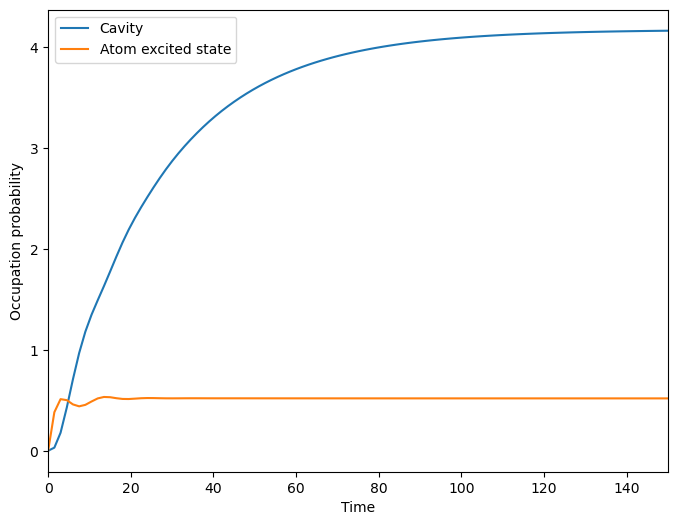

In [7]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.set_xlim(0, 150)
axes.legend(loc=0)
axes.set_xlabel("Time")
axes.set_ylabel("Occupation probability");

## Steady state: cavity fock-state distribution and wigner function

In [8]:
rho_ss = steadystate(H, c_ops)

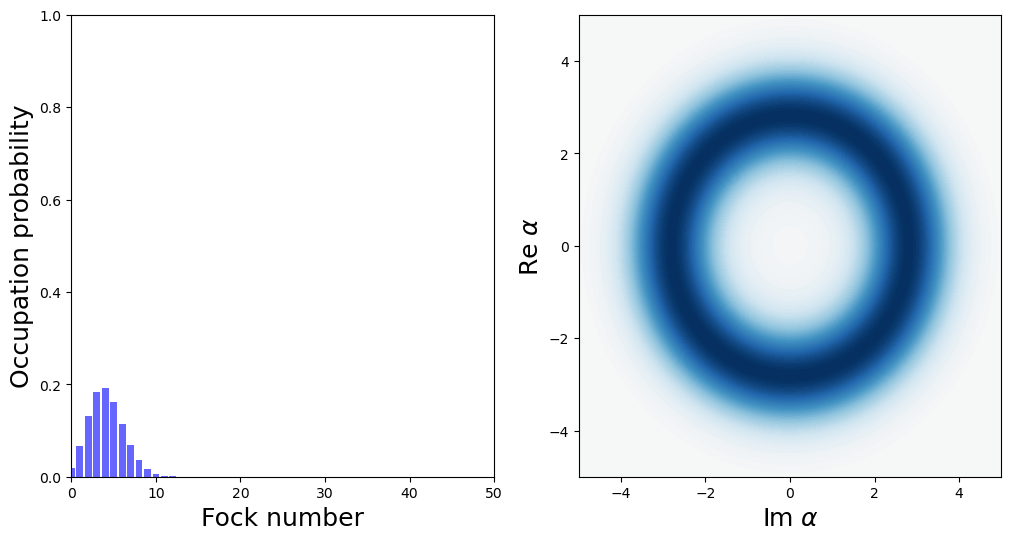

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

xvec = np.linspace(-5, 5, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue",
            alpha=0.6)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N)
axes[0].set_xlabel("Fock number", fontsize=18)
axes[0].set_ylabel("Occupation probability", fontsize=18);

## Cavity fock-state distribution and Wigner function as a function of time

In [10]:
tlist = np.linspace(0, 25, 5)
output = mesolve(H, psi0, tlist, c_ops, [],
                 options=Options(nsteps=5000))

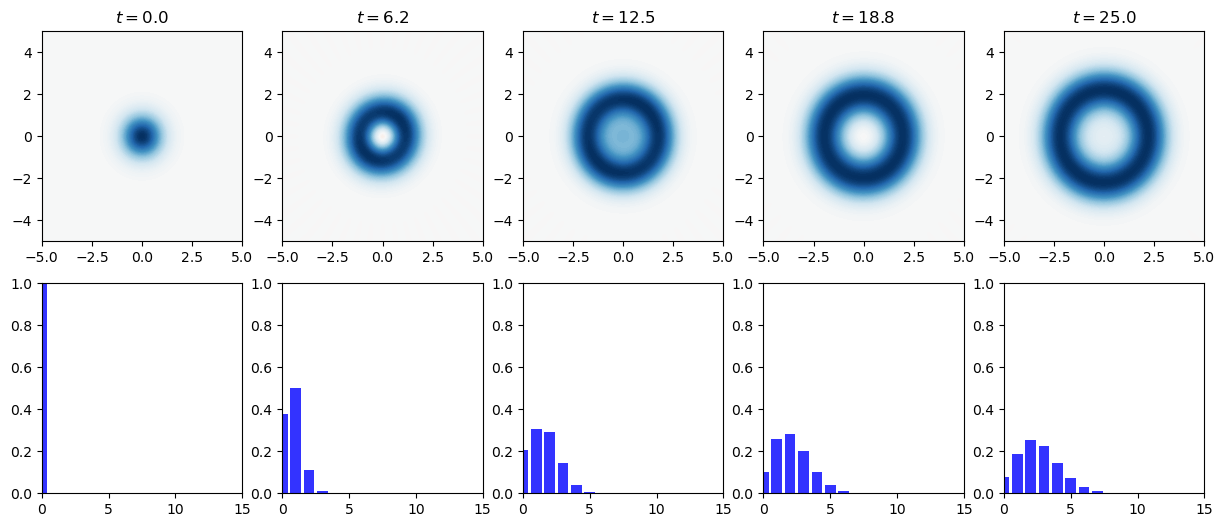

In [11]:
rho_ss_sublist = output.states

xvec = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, len(rho_ss_sublist),
                         figsize=(3 * len(rho_ss_sublist), 6))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)

    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)

    # plot its wigner function
    wlim = abs(W).max()
    axes[0, idx].contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-wlim, wlim),
        cmap=plt.get_cmap("RdBu"),
    )
    axes[0, idx].set_title(r"$t = %.1f$" % tlist[idx])

    # plot its fock-state distribution
    axes[1, idx].bar(np.arange(0, N), np.real(rho_ss_cavity.diag()),
                     color="blue", alpha=0.8)
    axes[1, idx].set_ylim(0, 1)
    axes[1, idx].set_xlim(0, 15)

## Steady state average photon occupation in cavity as a function of pump rate

References:

 * [S. Ashhab, J.R. Johansson, A.M. Zagoskin, F. Nori, New J. Phys. 11, 023030 (2009)](http://dx.doi.org/10.1088/1367-2630/11/2/023030)

In [12]:
def calculate_avg_photons(N, Gamma):

    # collapse operators
    c_ops = []

    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a)

    rate = kappa * n_th_a
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a.dag())

    rate = gamma
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * sm)

    rate = Gamma
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * sm.dag())

    # Ground state and steady state for the Hamiltonian: H = H0 + g * H1
    rho_ss = steadystate(H, c_ops)

    # cavity photon number
    n_cavity = expect(a.dag() * a, rho_ss)

    # cavity second order coherence function
    g2_cavity = expect(a.dag() * a.dag() * a * a, rho_ss) / (n_cavity**2)

    return n_cavity, g2_cavity

In [13]:
Gamma_max = 2 * (4 * g**2) / kappa
Gamma_vec = np.linspace(0.1, Gamma_max, 50)

n_avg_vec = []
g2_vec = []

for Gamma in Gamma_vec:
    n_avg, g2 = calculate_avg_photons(N, Gamma)
    n_avg_vec.append(n_avg)
    g2_vec.append(g2)

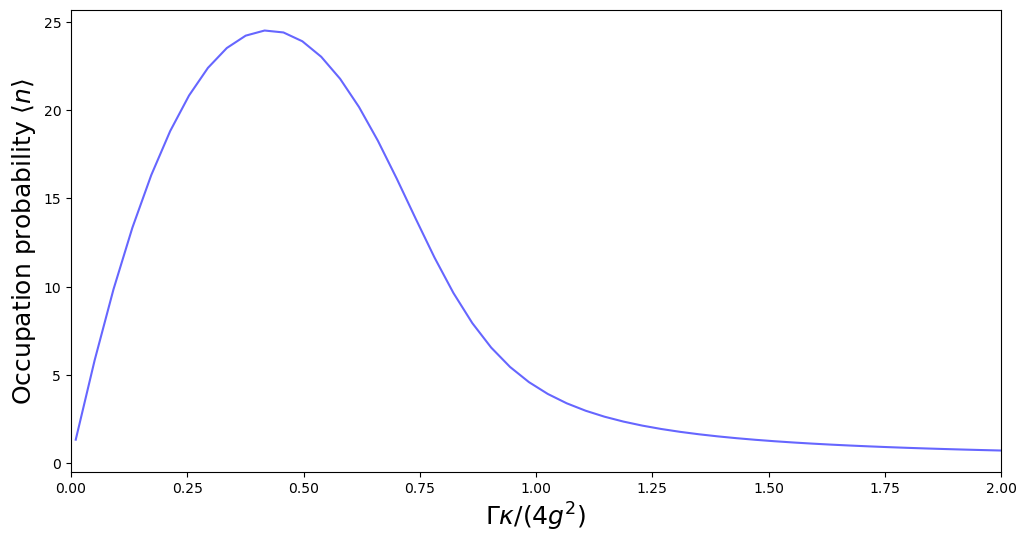

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.plot(
    Gamma_vec * kappa / (4 * g**2),
    n_avg_vec,
    color="blue",
    alpha=0.6,
    label="numerical",
)

axes.set_xlabel(r"$\Gamma\kappa/(4g^2)$", fontsize=18)
axes.set_ylabel(r"Occupation probability $\langle n \rangle$",
                fontsize=18)
axes.set_xlim(0, 2);

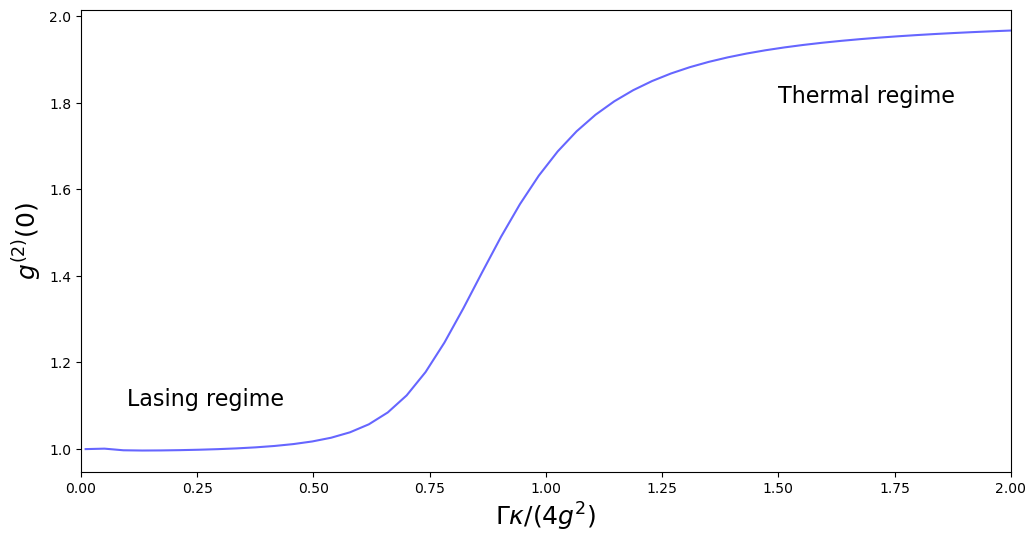

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.plot(Gamma_vec * kappa / (4 * g**2), g2_vec, color="blue", alpha=0.6,
          label="numerical")

axes.set_xlabel(r"$\Gamma\kappa/(4g^2)$", fontsize=18)
axes.set_ylabel(r"$g^{(2)}(0)$", fontsize=18)
axes.set_xlim(0, 2)
axes.text(0.1, 1.1, "Lasing regime", fontsize=16)
axes.text(1.5, 1.8, "Thermal regime", fontsize=16);

Here we see that lasing is suppressed for $\Gamma\kappa/(4g^2) > 1$. 


Let's look at the fock-state distribution at $\Gamma\kappa/(4g^2) = 0.5$  (lasing regime) and $\Gamma\kappa/(4g^2) = 1.5$ (suppressed regime):

### Case 1: $\Gamma\kappa/(4g^2) = 0.5$

In [16]:
Gamma = 0.5 * (4 * g**2) / kappa

In [17]:
c_ops = [
    np.sqrt(kappa * (1 + n_th_a)) * a,
    np.sqrt(kappa * n_th_a) * a.dag(),
    np.sqrt(gamma) * sm,
    np.sqrt(Gamma) * sm.dag(),
]

rho_ss = steadystate(H, c_ops)

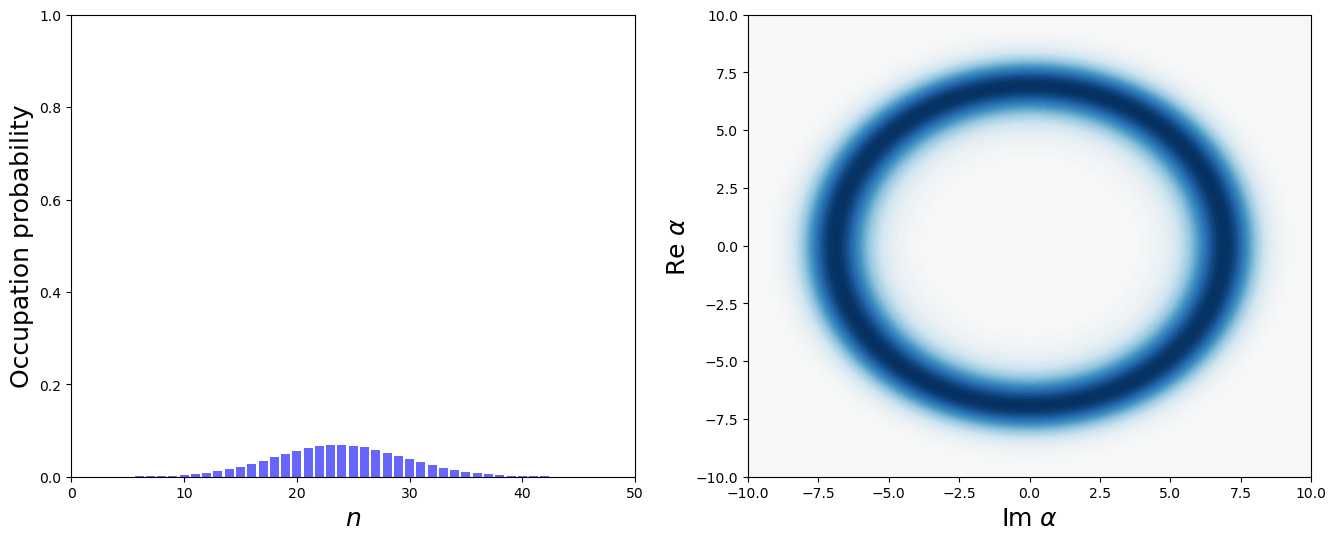

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

xvec = np.linspace(-10, 10, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()
axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue",
            alpha=0.6)
axes[0].set_xlabel(r"$n$", fontsize=18)
axes[0].set_ylabel(r"Occupation probability", fontsize=18)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N);

### Case 2: $\Gamma\kappa/(4g^2) = 1.5$

In [19]:
Gamma = 1.5 * (4 * g**2) / kappa

In [20]:
c_ops = [
    np.sqrt(kappa * (1 + n_th_a)) * a,
    np.sqrt(kappa * n_th_a) * a.dag(),
    np.sqrt(gamma) * sm,
    np.sqrt(Gamma) * sm.dag(),
]

rho_ss = steadystate(H, c_ops)

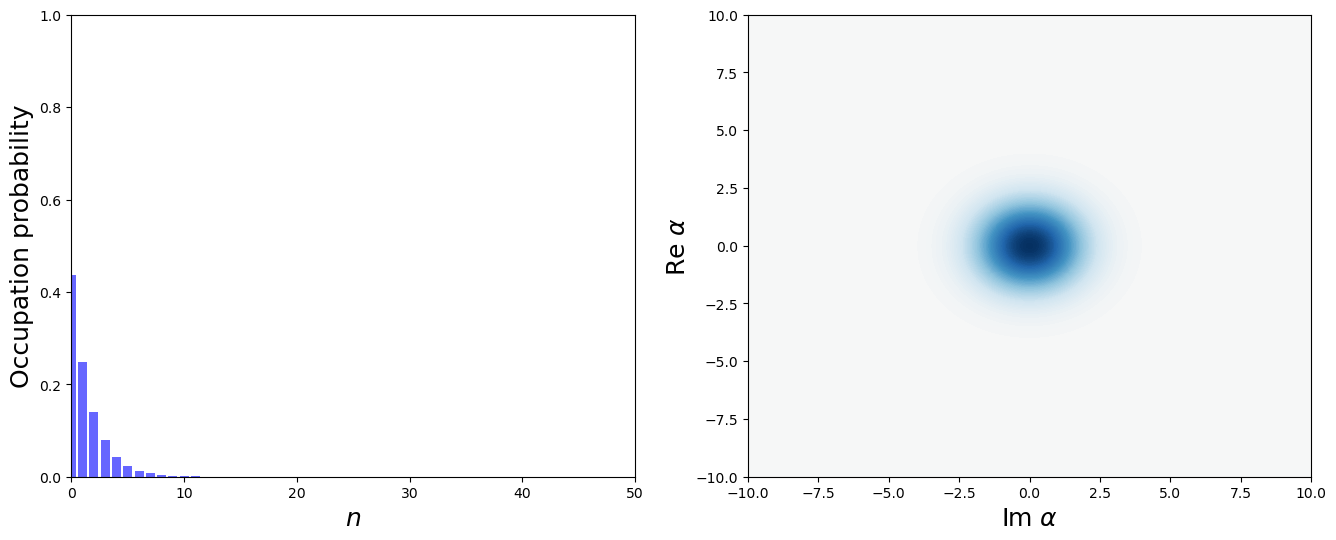

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

xvec = np.linspace(-10, 10, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()
axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue",
            alpha=0.6)
axes[0].set_xlabel(r"$n$", fontsize=18)
axes[0].set_ylabel(r"Occupation probability", fontsize=18)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N);

Too large pumping rate $\Gamma$ kills the lasing process: reversed threshold.

### Software version

In [22]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer